In [1]:
# Import Modul yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.express as px
import missingno
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [2]:
df_gold = pd.read_csv('annual_csv.csv')
df_gold.head()

,Date,Price
0,1950-12,34.72
1,1951-12,34.66
2,1952-12,34.79
3,1953-12,34.85
4,1954-12,35.04


In [3]:
df_gold_monthly = pd.read_csv('monthly_csv.csv')
df_gold_monthly.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
# format date correctly & get month & year
df_gold_monthly['Date'] = pd.to_datetime(df_gold_monthly['Date'], format = '%Y-%m-%d')
df_gold_monthly['Year'], df_gold_monthly['Month'], = df_gold_monthly['Date'].dt.year, df_gold_monthly['Date'].dt.month

In [5]:
df_gold_monthly['Date']

0     1950-01-01
1     1950-02-01
2     1950-03-01
3     1950-04-01
4     1950-05-01
         ...    
842   2020-03-01
843   2020-04-01
844   2020-05-01
845   2020-06-01
846   2020-07-01
Name: Date, Length: 847, dtype: datetime64[ns]

In [6]:
df_gold.describe()

,Price
count,70.000000
mean,412.776457
std,444.932209
min,34.660000
25%,35.277500
50%,320.803500
75%,458.943500
max,1687.342000


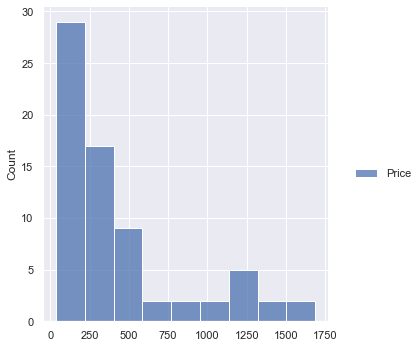

In [7]:
sns.displot(df_gold)

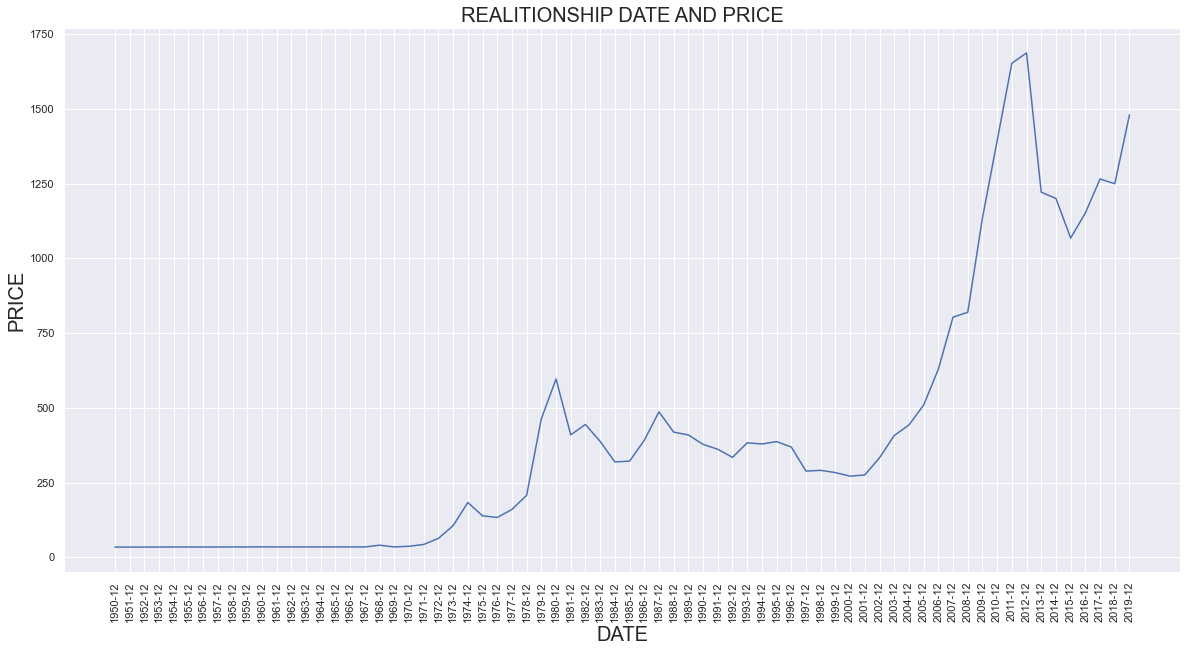

In [8]:
plt.figure(figsize=(20,10))
sns.lineplot(y="Price",x="Date",data=df_gold)
plt.title("REALITIONSHIP DATE AND PRICE",fontsize=20)
plt.xlabel("DATE",fontsize=20)
plt.xticks(rotation=90)
plt.ylabel("PRICE",fontsize=20)
plt.show()

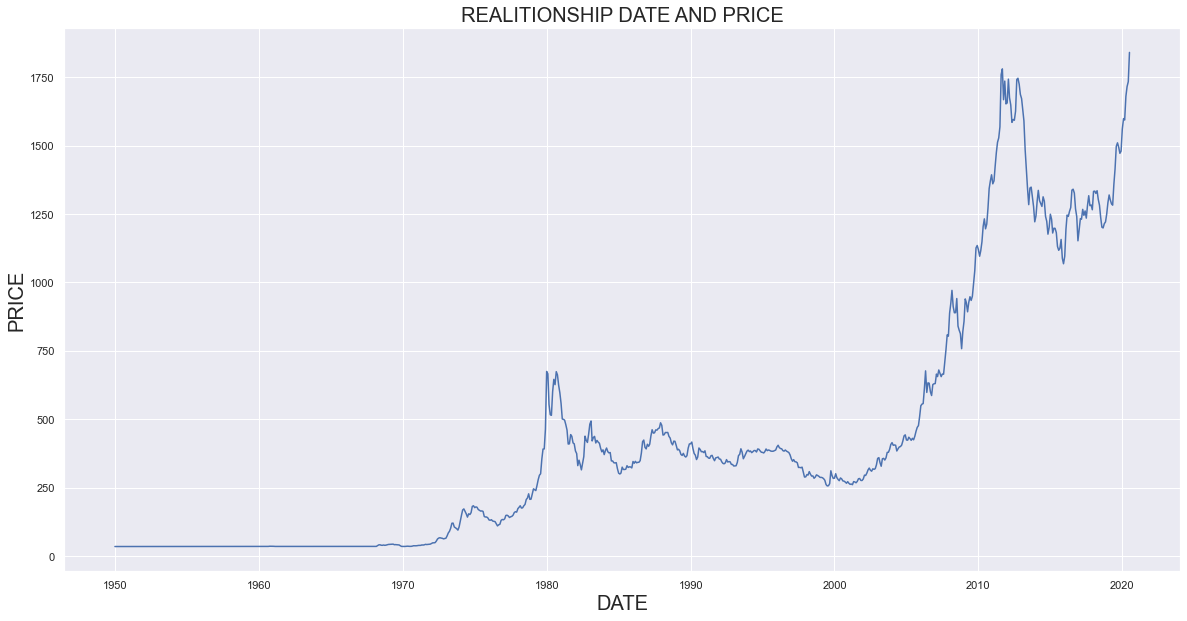

In [9]:
plt.figure(figsize=(20,10))
sns.lineplot(y="Price",x="Date",data=df_gold_monthly)
plt.title("REALITIONSHIP DATE AND PRICE",fontsize=20)
plt.xlabel("DATE",fontsize=20)
plt.ylabel("PRICE",fontsize=20)
plt.show()

In [10]:
df_gold_monthly['Year']

0      1950
1      1950
2      1950
3      1950
4      1950
       ... 
842    2020
843    2020
844    2020
845    2020
846    2020
Name: Year, Length: 847, dtype: int64

In [11]:
df_gold_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    847 non-null    datetime64[ns]
 1   Price   847 non-null    float64       
 2   Year    847 non-null    int64         
 3   Month   847 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 26.6 KB


## Train Test Split

In [12]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df_gold_monthly['Date']
y = df_gold_monthly['Price']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

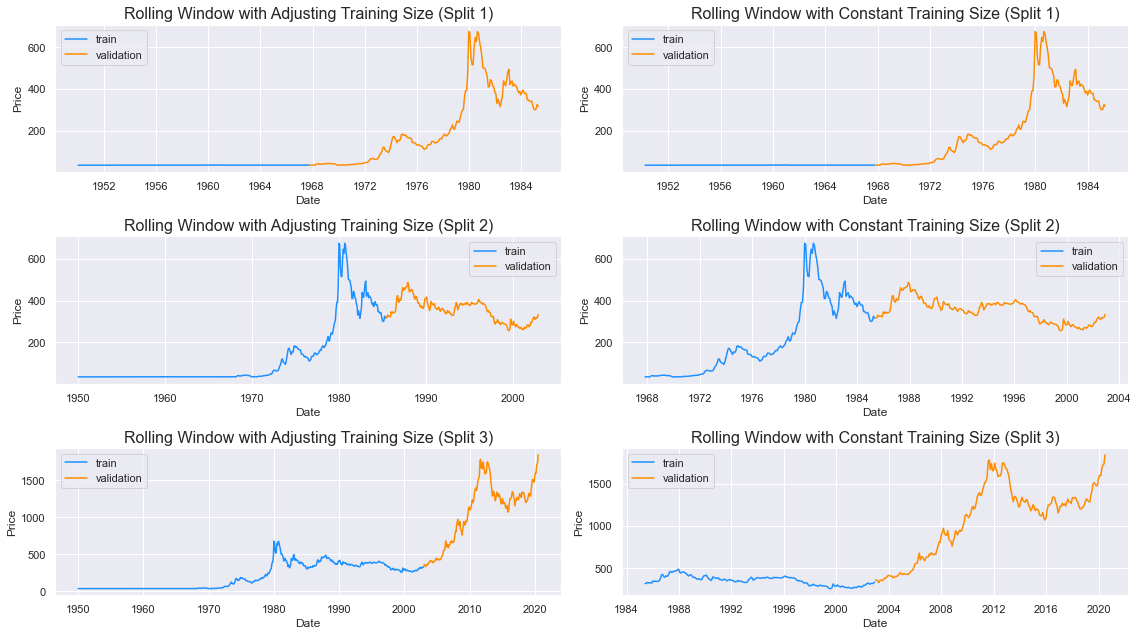

In [13]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)
    
plt.tight_layout()
plt.show()

In [14]:
train_size = int(0.85 * len(df_gold_monthly))
test_size = len(df_gold_monthly) - train_size

univariate_df = df_gold_monthly[['Date', 'Price']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

719 128


In [15]:
y_valid

,y
719,1135.012
720,1119.575
721,1095.800
722,1115.554
723,1148.475
...,...
842,1593.764
843,1680.030
844,1715.697
845,1734.032


In [16]:
x_valid

,ds
719,2009-12-01
720,2010-01-01
721,2010-02-01
722,2010-03-01
723,2010-04-01
...,...
842,2020-03-01
843,2020-04-01
844,2020-05-01
845,2020-06-01


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(128)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

from colorama import Fore
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 238.50559880759928


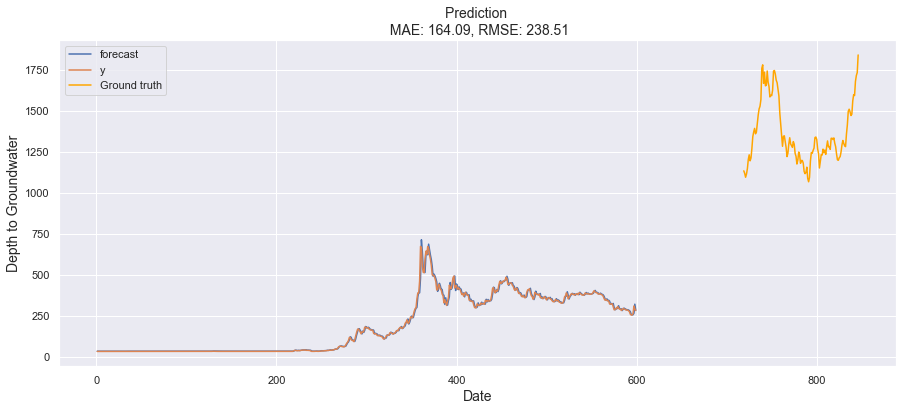

In [18]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Price of Gold') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Price of Gold', fontsize=14)

plt.show()

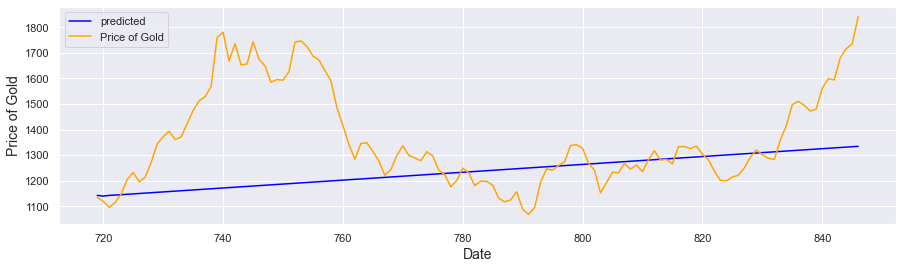

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Price of Gold') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Price of Gold', fontsize=14)

plt.show()

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6176.393, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6210.651, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6187.042, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6179.121, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6213.623, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6176.758, Time=1.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6177.323, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6175.343, Time=0.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6177.300, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6179.342, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6177.472, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 6.811 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

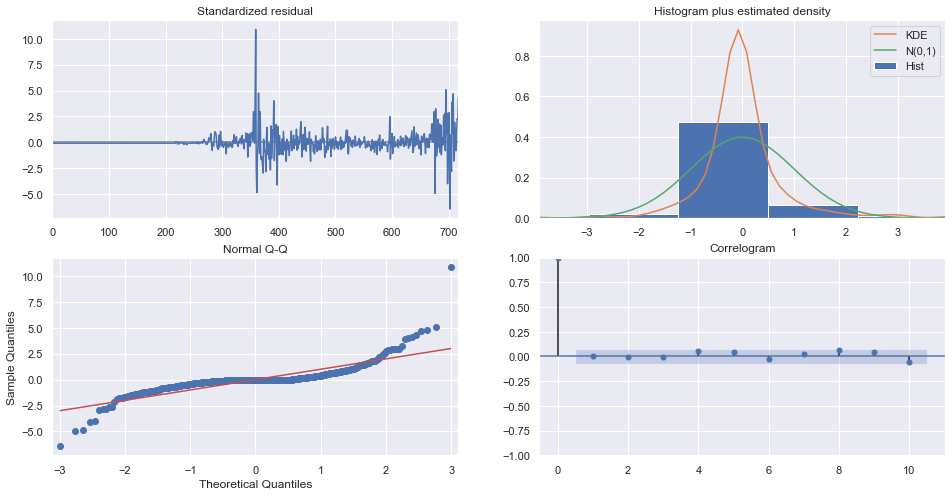

In [21]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713],
       [-0.99986713]])

In [23]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

615 128


In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
615/615 [==============================] - 43s 44ms/step - loss: 0.0369 - val_loss: 0.0222
Epoch 2/5
615/615 [==============================] - 5s 9ms/step - loss: 0.0017 - val_loss: 0.0140
Epoch 3/5
615/615 [==============================] - 5s 9ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 4/5
615/615 [==============================] - 5s 8ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 5/5
615/615 [==============================] - 5s 8ms/step - loss: 0.0012 - val_loss: 0.0073
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            92672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
_____________________

In [25]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 154.65558952857486


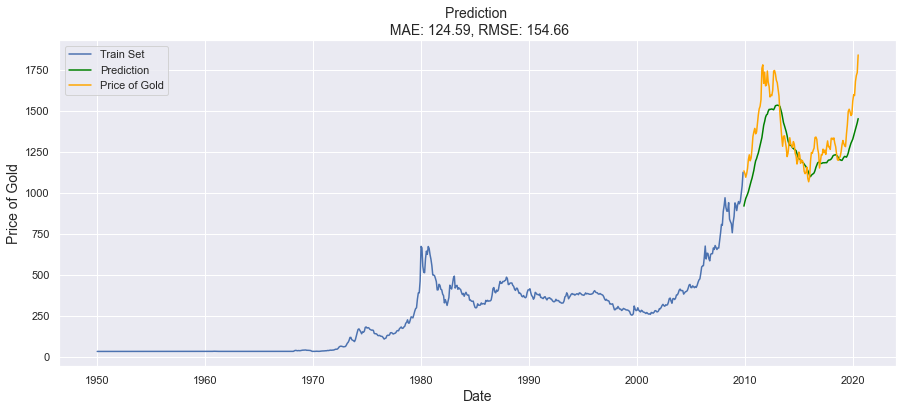

In [28]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Price of Gold') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Price of Gold', fontsize=14)

plt.show()